In [1]:
import jax
import jax.numpy as jnp

In [2]:
def magnetization_z(samples: jnp.ndarray) -> jnp.ndarray: # (num_samples, num_qubits)
    spins = 1 - 2 * samples  # map 0 -> +1, 1 -> -1
    return spins.mean() # we want the global mean


def amplitude_ratio_flip(rbm_amp, sample: jnp.ndarray, flip_idx: int) -> jnp.ndarray: # sample still 0 1 encoded AND a batch
    spin_flipped = 1 - sample[:, flip_idx]
    sample_flipped = sample.at[:, flip_idx].set(spin_flipped)

    free_energy_reference = rbm_amp._free_energy(sample)
    free_energy_flipped = rbm_amp._free_energy(sample_flipped)

    amplitude_ratio = jnp.exp((free_energy_reference - free_energy_flipped) / 2)
    return amplitude_ratio


def magnetization_x(rbm_amp, samples: jnp.ndarray) -> jnp.ndarray:

    amplitude_ratio_flip_fn = lambda flip_idx: amplitude_ratio_flip(rbm_amp, samples, flip_idx)  # (batch_size,)

    spin_indices = jnp.arange(samples.shape[1])
    qubit_ratios = jax.vmap(amplitude_ratio_flip_fn)(spin_indices)  # (num_qubits, batch_size)

    magnetization = qubit_ratios.mean()
    return magnetization

In [3]:
class MockRBM:
    def _free_energy(self, samples: jnp.ndarray) -> jnp.ndarray:
        return jnp.zeros(samples.shape[0])

mock_rbm = MockRBM()
all_samples = jnp.array([list(map(int, format(i, '04b'))) for i in range(16)])

mz = magnetization_z(all_samples)
mx = magnetization_x(mock_rbm, all_samples)

print(f"Test Samples (4-bit) shape: {all_samples.shape}")
print(f"Global sigma_z (expected 0): {mz:.5f}")
print(f"Global sigma_x with uniform psi (1): {mx:.5f}")

Test Samples (4-bit) shape: (16, 4)
Global sigma_z (expected 0): 0.00000
Global sigma_x with uniform psi (1): 1.00000


In [4]:
# calculate magentization for a given state vector

def magnetization_z_from_state(state: jnp.ndarray) -> jnp.ndarray:
    state_size = state.shape[0]
    num_qubits = int(jnp.log2(state.shape[0]))
    assert 2**num_qubits ==state_size, "State vector length must be a power of 2."

    probs = jnp.abs(state)**2 # born rule gives frequencies

    basis_indices = jnp.arange(state_size)                          # (2**n,)
    bitstrings = ((basis_indices[:, None] >> jnp.arange(num_qubits)[::-1]) & 1)  # (2**n, n)
    spins = 1.0 - 2.0 * bitstrings

    magnetization_vector = spins.mean(axis=1)

    magnetization = jnp.sum(probs * magnetization_vector)
    return magnetization


def overlap_after_spin_flip(state: jnp.ndarray, num_qubits: int, flip_idx: int) -> jnp.ndarray:
    basis_indices = jnp.arange(2**num_qubits)
    mask = 1 << (num_qubits - 1 - flip_idx)  # flip bit at position flip_idx
    flipped_indices = basis_indices ^ mask   # bit-flipped indices
    return jnp.vdot(state, state[flipped_indices]).real


def magnetization_x_from_state(state: jnp.ndarray) -> jnp.ndarray:
    num_qubits = int(jnp.log2(state.shape[0]))
    overlaps = jnp.array([overlap_after_spin_flip(state, num_qubits, i) for i in range(num_qubits)])
    return overlaps.mean()

In [5]:
# Uniform state (real)
n = 4
uniform_state = jnp.ones(2**n) / jnp.sqrt(2**n)

mz = magnetization_z_from_state(uniform_state)
mx = magnetization_x_from_state(uniform_state)

print(f"Uniform 4-qubit state")
print(f"Magnetization Z (expected 0): {mz:.5f}")
print(f"Magnetization X (expected 1): {mx:.5f}")

Uniform 4-qubit state
Magnetization Z (expected 0): 0.00000
Magnetization X (expected 1): 1.00000


In [8]:
magnetizations = [2.0, 2.5, 2.8, 2.9, 3.0, 3.1, 3.2, 3.5, 4.0]

file_names = [
    "tfim_h2.00_3x3.txt",
    "tfim_h2.50_3x3.txt",
    "tfim_h2.80_3x3.txt",
    "tfim_h2.90_3x3.txt",
    "tfim_h3.00_3x3.txt",
    "tfim_h3.10_3x3.txt",
    "tfim_h3.20_3x3.txt",
    "tfim_h3.50_3x3.txt",
    "tfim_h4.00_3x3.txt"
]



state_vectors = []
for file in file_names:
    file_path = "./data/" + file

    with open(file_path, 'r') as f:
        values = [float(line.strip()) for line in f]
        state_vectors.append(jnp.array(values))

In [10]:
# iterate over state vectors and calculate magnetizations

magnetizations_z_state = []
magnetizations_x_state = []
for i, state in enumerate(state_vectors):
    mz = magnetization_z_from_state(state)
    mx = magnetization_x_from_state(state)

    magnetizations_z_state.append(mz)
    magnetizations_x_state.append(mx)

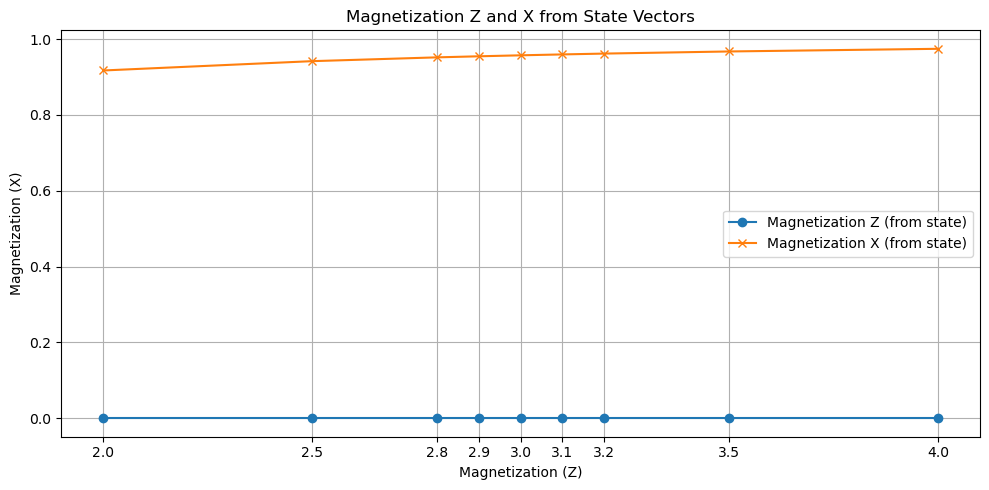

In [11]:
# draw magnetization z and x

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(magnetizations, magnetizations_z_state, marker='o', label='Magnetization Z (from state)')
plt.plot(magnetizations, magnetizations_x_state, marker='x', label='Magnetization X (from state)')
plt.xlabel('Magnetization (Z)')
plt.ylabel('Magnetization (X)')
plt.title('Magnetization Z and X from State Vectors')
plt.xticks(magnetizations)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# book keeping

# Array(0.96195567, dtype=float32)
# Array(0.25225806, dtype=float32)

# Array(0.82402235, dtype=float32)
# Array(0.56132346, dtype=float32)

# Array(0.5796, dtype=float32)
# Array(0.8218158, dtype=float32)